### CS 512 Computer Vision
### Final Project
### Brain Tumor Classification using Convolutional Neural Network
*Authors*
- Kinjal Kachi (A20449343)
- Omkar Pawar (A20448802)

# Data Modeling
In this notebook, we build few models on the data we created. We use training and validation sets that we saved in data wrangling stage.

The steps that we will go through are as follows
- Load training and validation sets
- Create a simple convolutional neural network
- Implement Data Augumentation to create model
- Try Transfer Learning using ResNet50
- Evaluate the models based on accuracy metric


Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import cv2
from keras.layers.normalization import BatchNormalization
from keras import models, layers

from google.colab import drive
import pickle
from keras import backend as K
from keras.applications.resnet50 import ResNet50
from keras import Input

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

drive.mount('/content/drive')

Mounted at /content/drive


# Load Training and Validation Sets
Load the pickled data that we created in Data Wrangling notebook

In [2]:
#Loading data from pickle file (unnecesary step if data has been fectched from drive)

pickledir="/content/drive/My Drive/Colab Notebooks/dataset/newbraindata_stratified.pickle"
trainx,trainy,testx,testy=pickle.load(open(pickledir,"rb"))

np.random.seed(0)

# Convert labels to categorical datatype
trainy = to_categorical(trainy)
testy = to_categorical(testy)

tf.keras.backend.clear_session()

# Data Modeling
Here we start modeling out data by create a network architecture and then improving it as required. This model is the optimized version of the models that we tried till now. In the model given below, we have the values as follows.

- The model consists of 2 convoulutional layers with Max pooling and batch normalization
At the end we flatten the results of this layer and and add 2 fully connected dense layers, one with 64 neurons and one with 3, which is the label of the given image and also known as output layer.

- We have kept the stride of (2,2) for all convolutional layers and used 64 filters. Activation function for hidden layers is relu and on output layer we use softmax.

- While compiling the model, we minimize the categorical_crossentropy loss function and evaluate the model based on the accuracy.

In [ ]:
# Define a sequential model
model = models.Sequential()

# Add Input layer which takes the images of shape (512,512,1)
model.add(layers.Conv2D(64,(5,5),strides= (2,2), activation = 'relu',kernel_initializer= "glorot_uniform", 
                                  input_shape = (512,512,1)))
model.add(layers.MaxPooling2D((2,2)))
model.add(BatchNormalization())

# Block 2
model.add(layers.Conv2D(64,(3,3),strides= (2,2), activation = 'relu',kernel_initializer= "glorot_uniform"))
model.add(layers.MaxPooling2D((2,2)))
model.add(BatchNormalization())
model.add(layers.Dropout(0.3))

# Flatten the output of previous layers
model.add(layers.Flatten())

# Add dense layer
model.add(layers.Dense(64,activation='relu'))
# Output layer
model.add(layers.Dense(3,activation='softmax'))

#Show the model summary
model.summary()

# Fit model on training data and validate the accuracy on validation set.
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics = ["accuracy"])
history = model.fit(trainx,trainy,epochs=20,batch_size=64,validation_data=(testx,testy))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 254, 254, 64)      1664      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 127, 127, 64)      256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 31, 31, 64)       

Plot loss and accuracy values for training and validation set.

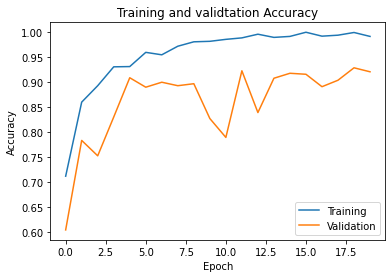

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validtation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])

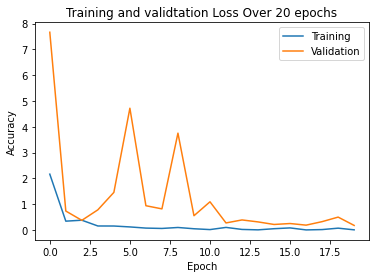

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validtation Loss Over 20 epochs')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])

# Data Augumentation
This step is generally done in data preprocessing where we make changes to existing features like flip, rotation, skew, shear, etc to generate new samples of same image to get different point of views. We have done data augmentation using ImageDataGenerator in keras where it augments the data randomly in the runtime, while the model is being trained.

We tried implementing data augmentation in hope that the model will generalize better. In the above results we can see that even though the model performs good on validation data, it seems to overfit the training data. Hence anticipating better results using different views of the image, we used data augmentation.

Here we have defined a data generator which randomly flips the image horizontally and vertically and also rotates it by the scale of 90.

In [ ]:
datagen = ImageDataGenerator(rotation_range=90,horizontal_flip=True,vertical_flip=True)
datagen.fit(trainx)

In [ ]:
dataaug_model = models.Sequential()

# Add Input layer which takes the images of shape (512,512,1)
dataaug_model.add(layers.Conv2D(64,(5,5),strides= (2,2), activation = 'relu',kernel_initializer= "glorot_uniform", 
                                  input_shape = (512,512,1)))
dataaug_model.add(layers.MaxPooling2D((2,2)))
dataaug_model.add(BatchNormalization())

# Block 2
dataaug_model.add(layers.Conv2D(64,(3,3),strides= (2,2), activation = 'relu',kernel_initializer= "glorot_uniform"))
dataaug_model.add(layers.MaxPooling2D((2,2)))
dataaug_model.add(layers.Dropout(0.3))
dataaug_model.add(BatchNormalization())

# Flatten the output of previous layers
dataaug_model.add(layers.Flatten())

# Add dense layer
dataaug_model.add(layers.Dense(64,activation='relu'))
# Output layer
dataaug_model.add(layers.Dense(3,activation='softmax'))

#Show the model summary
dataaug_model.summary()

# Fit model on training data and validate the accuracy on validation set.
dataaug_model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics = ["accuracy"])
history_dataaug_ = dataaug_model.fit(datagen.flow(trainx,trainy, batch_size=32),epochs=20,batch_size=64,validation_data=(testx,testy))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 254, 254, 64)      1664      
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 127, 127, 64)      0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 127, 127, 64)      256       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 63, 63, 64)        36928     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 31, 31, 64)       

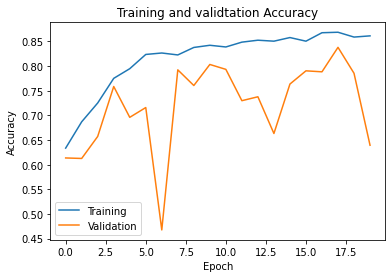

In [ ]:
plt.plot(history_dataaug_.history['accuracy'])
plt.plot(history_dataaug_.history['val_accuracy'])
plt.title('Training and validtation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])

# Transfer Learning
The networks that we implemented above had few layers and if we wish to build deeper neural networks, it would take a lot of time to train and find the optimal weights and biases. One step to cut this process short and make it more efficient is transfer learning. In this approach, we try to use the weights of already trained models and just change the input and output layers to make it work for our problem. One of such network for image classification is ResNet 50 (Residual Network). 

- ResNet50

A residual neural network is an artificial neural network of a kind that builds on constructs known from pyramidal cells in the cerebral cortex. Residual neural networks do this by utilizing skip connections, or shortcuts to jump over some layers. Details of this model are given in the report. Here we will just load the pretrained ResNet model using imagenet weights and discard the output layers. We will also change the input shape parameter to (512,512,3). Notice that we have converted out training and testing features to 3-channel images as ResNet works only on RGB.
Also, we freeze most of the layers to reduce the training time. If not done, the notebook crashes as it can't handle such large parameter computations.

We print the summary of imported resnet model and then add our layers to train the model on our data

In [3]:
def grayscale_to_rgb(images, channel_axis=-1):
    #images= K.expand_dims(images, axis=channel_axis)
    tiling = [1] * 4    # 4 dimensions: B, H, W, C
    tiling[channel_axis] *= 3
    images= K.tile(images, tiling)
    return images

rgb_train = grayscale_to_rgb(trainx)
rgb_test = grayscale_to_rgb(testx)
rgb_test.shape

TensorShape([1007, 512, 512, 3])

In [4]:
in_shape = Input(shape = (512,512,3))
# load model

res_model = ResNet50(include_top=False,
                 input_tensor=in_shape,
                 weights = "imagenet")

for layer in res_model.layers[:143]:
  layer.trainable = False
# summarize the model
res_model.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 518, 518, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 256, 256, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 256, 256, 64) 256         conv1_conv[0][0]                 
__________________________

In [5]:
from keras import models, layers
renet50_model = models.Sequential()
renet50_model.add(res_model)
renet50_model.add(layers.Flatten())
renet50_model.add(layers.Dense(3, activation='softmax'))
renet50_model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history_renet50 = renet50_model.fit(rgb_train, trainy, batch_size=32,epochs = 5,validation_data=(rgb_test,testy))

Epoch 1/5
64/64 [==============================] - 1498s 23s/step - loss: 4.6537 - accuracy: 0.7733 - val_loss: 85445.6172 - val_accuracy: 0.5958
Epoch 2/5
64/64 [==============================] - 1501s 23s/step - loss: 2.4372 - accuracy: 0.8428 - val_loss: 26365.4062 - val_accuracy: 0.5740
Epoch 3/5
64/64 [==============================] - 1501s 23s/step - loss: 0.9640 - accuracy: 0.8918 - val_loss: 746.3751 - val_accuracy: 0.7498
Epoch 4/5
64/64 [==============================] - 1501s 23s/step - loss: 1.1327 - accuracy: 0.9109 - val_loss: 16.7748 - val_accuracy: 0.8401
Epoch 5/5
64/64 [==============================] - 1500s 23s/step - loss: 0.7152 - accuracy: 0.9236 - val_loss: 1.1077 - val_accuracy: 0.8580


In [8]:
renet50_model.compile(loss="categorical_crossentropy",optimizer="adam",metrics=["accuracy"])
history_renet50 = renet50_model.fit(rgb_train, trainy, batch_size=32,epochs = 5,validation_data=(rgb_test,testy))

Epoch 1/5
64/64 [==============================] - 1500s 23s/step - loss: 3.7656 - accuracy: 0.9182 - val_loss: 8.2532 - val_accuracy: 0.7547
Epoch 2/5
64/64 [==============================] - 1495s 23s/step - loss: 4.6307 - accuracy: 0.9197 - val_loss: 29.3252 - val_accuracy: 0.8093
Epoch 3/5
64/64 [==============================] - 1510s 24s/step - loss: 0.4828 - accuracy: 0.9447 - val_loss: 85.2816 - val_accuracy: 0.8560
Epoch 4/5
64/64 [==============================] - 1496s 23s/step - loss: 2.5151 - accuracy: 0.9549 - val_loss: 4.6789 - val_accuracy: 0.8352
Epoch 5/5
64/64 [==============================] - 1507s 24s/step - loss: 1.6482 - accuracy: 0.9476 - val_loss: 17.9881 - val_accuracy: 0.8689


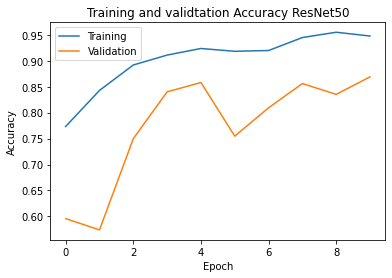

In [10]:
plt.plot(history_renet50.history['accuracy'])
plt.plot(history_renet50.history['val_accuracy'])
plt.title('Training and validtation Accuracy for ResNet50')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])

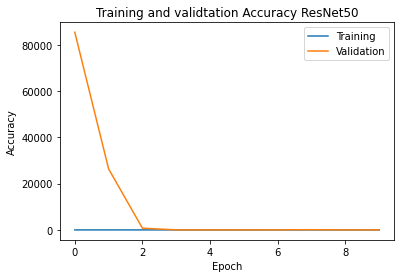

In [11]:
plt.plot(history_renet50.history['loss'])
plt.plot(history_renet50.history['val_loss'])
plt.title('Training and validtation Loss for ResNet50')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'])

We can see that the ResNet model overfits training data but fails to perform on validation set.

### Final Thoughts
- From the results we can see that the model which we define performs better than other approaches that we implement. Other models are more complex as compared to Model1. 
- The model that uses augmented data fails as the classifier also depends on the orientation of the images and changing the images won’t help get better performance of the model. 
- The approach of transfer learning using ResNet 50 architecture surely gave better results. We freezed most of the layers to keep the trainable parameters less, but still it takes longer to run. And being a more complex and deeper model, it tends to overfit the data. We hope this would be different  if we let all the layers train, but we didn’t have the resources to do so at the present time. In future, we plan to train the whole ResNet model allowing all the layers to update their values.
